In [4]:
%matplotlib inline
import os
import sys
sys.path.append('/root/capsule/code/beh_ephys_analysis')
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
import json
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import re
from beh_functions import parseSessionID, session_dirs
from plot_untils import shiftedColorMap, template_reorder
from open_ephys.analysis import Session##
import spikeinterface as si
import spikeinterface.extractors as se
import spikeinterface.postprocessing as spost
import spikeinterface.widgets as sw
from aind_dynamic_foraging_basic_analysis.licks.lick_analysis import load_nwb
from aind_ephys_utils import align
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colormaps
from aind_dynamic_foraging_data_utils.nwb_utils import load_nwb_from_filename


# Create a white-to-bright red colormap
colors = [(1, 1, 1), (1, 0, 0)]  # white to red
my_red = LinearSegmentedColormap.from_list("white_to_red", colors)

## Check behavior

In [103]:
session_df = pd.read_csv('/root/capsule/aind-beh-ephys-analysis/code/data_management/session_assets.csv')
session_ids = session_df['session_id'].unique()
session_ids

array(['behavior_716325_2024-05-29_10-33-32',
       'behavior_716325_2024-05-30_11-33-46',
       'behavior_716325_2024-05-31_10-31-14',
       'behavior_716325_2024-06-01_09-25-37',
       'behavior_717121_2024-06-11_10-23-31',
       'behavior_717121_2024-06-13_12-21-20',
       'behavior_717121_2024-06-14_10-23-49',
       'behavior_717121_2024-06-15_10-00-58',
       'behavior_717121_2024-06-16_11-45-02',
       'behavior_717259_2024-06-25_10-09-25',
       'behavior_717259_2024-06-26_10-23-07',
       'behavior_717259_2024-06-28_11-17-19',
       'behavior_717263_2024-07-23_11-46-42',
       'behavior_717263_2024-07-24_10-40-05',
       'behavior_717263_2024-07-25_10-02-21',
       'behavior_714116_2024-08-27_11-29-48',
       'behavior_714116_2024-08-28_12-11-55',
       'behavior_714116_2024-08-29_11-46-43',
       'behavior_722832_2024-09-13_11-55-58',
       'behavior_724172_2024-10-01_11-20-11',
       'behavior_724172_2024-10-03_11-02-53',
       'behavior_739970_2024-10-15

In [104]:
session_id = 'behavior_751004_2024-12-23_14-20-03'
session_dir = session_dirs(session_id)
session_dir

{'aniID': '751004',
 'raw_id': '751004_2024-12-23_14-20-03',
 'datetime': datetime.datetime(2024, 12, 23, 0, 0),
 'raw_dir': '/root/capsule/data/behavior_751004_2024-12-23_14-20-03_raw_data',
 'session_dir': '/root/capsule/data/behavior_751004_2024-12-23_14-20-03_raw_data/ecephys/ecephys_clipped',
 'processed_dir': '/root/capsule/scratch/751004/behavior_751004_2024-12-23_14-20-03',
 'alignment_dir': '/root/capsule/scratch/751004/behavior_751004_2024-12-23_14-20-03/alignment',
 'beh_fig_dir': '/root/capsule/scratch/751004/behavior_751004_2024-12-23_14-20-03/behavior',
 'ephys_fig_dir': '/root/capsule/scratch/751004/behavior_751004_2024-12-23_14-20-03/ephys',
 'opto_fig_dir': '/root/capsule/scratch/751004/behavior_751004_2024-12-23_14-20-03/opto',
 'opto_tag_dir': '/root/capsule/scratch/751004/behavior_751004_2024-12-23_14-20-03/opto_tag',
 'opto_tag_fig_dir': '/root/capsule/scratch/751004/behavior_751004_2024-12-23_14-20-03/opto_tag/figures',
 'nwb_dir': '/root/capsule/data/behavior_751

In [105]:
opto_dfs = [pd.read_csv(csv) for csv in session_dir['opto_csvs']]
opto_df = pd.concat(opto_dfs)
sites = np.sort(opto_df['site'].unique())
sites = [int(i) for i in sites]
if len(sites) == 1:
    sites = opto_df['emission_location'].unique()
powers = np.sort(opto_df['power'].unique())
powers = [float(i) for i in powers]
num_pulses = np.sort(opto_df['num_pulses'].unique())
num_pulses = [int(i) for i in num_pulses]
freqs = opto_df['param_group'].unique()
freqs = [int(re.search(r'train(.*?)Hz', freq).group(1)) for freq in freqs]
opto_df['freq'] = opto_df['param_group'].apply(lambda x: int(re.search(r'train(.*?)Hz', x).group(1)))
durations = np.sort(opto_df['duration'].unique())
durations = [float(i) for i in durations]
print('Sites:')
print(sites)
print('Powers:')
print(powers)
print('Freqs:')
print(freqs)
print('Pulse durations:')
print(durations)
print('Num pulses:')
print(num_pulses)

stim_params = {'sites': list(sites), 
                'powers': list(powers), 
                'freqs': list(freqs),
                'durations': list(durations),
                'num_pulses': list(num_pulses)}

Sites:
['surface_LC' 'surface_PrL' 'surface_S1' 'surface_V1']
Powers:
[10.0, 20.0, 30.0, 40.0, 50.0]
Freqs:
[5]
Pulse durations:
[4.0, 5.0]
Num pulses:
[5]


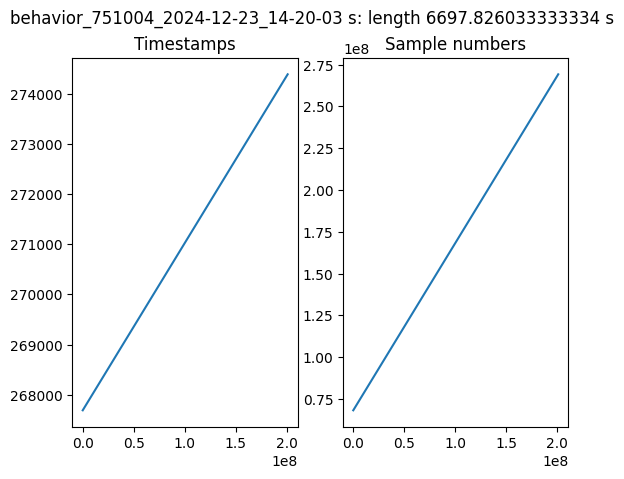

In [106]:
# load neuralpixel session
session = Session(session_dir['session_dir'])
recording = session.recordnodes[0].recordings[0]
timestamps = recording.continuous[0].timestamps
fig = plt.Figure(figsize=(10,2))
plt.subplot(1,2,1)
plt.plot(timestamps[:])
plt.title('Timestamps')
plt.subplot(1,2,2)
plt.plot(recording.continuous[0].sample_numbers)
plt.title('Sample numbers')
plt.suptitle(f'{session_id} s: length {len(timestamps)/30000} s')
plt.show()

In [107]:
# # if needs re-alignment
# ignore_after_time = 1712 # seconds
# recording.add_sync_line(1,            # TTL line number
#                         100,          # processor ID
#                         'ProbeA-AP',  # stream name
#                         main=True,    # set as the main stream
#                         ignore_intervals = [(ignore_after_time * 30000, np.inf)])    

# recording.add_sync_line(1,            # TTL line number                                       
#                         100,          # processor ID
#                         'ProbeA-LFP', # stream name
#                         ignore_intervals = [(ignore_after_time * 2500, np.inf)])

# recording.add_sync_line(1,            # TTL line number
#                         103,          # processor ID
#                         'PXIe-6341',   # stream name
#                         ignore_intervals = [(ignore_after_time * 30000, np.inf)])

# recording.compute_global_timestamps(overwrite=True)


In [108]:
# # for NP2.0 if needs re-alignment
# ignore_after_time = 200*60 # seconds
# recording.add_sync_line(1,            # TTL line number
#                         100,          # processor ID
#                         'ProbeA',  # stream name
#                         main=True,    # set as the main stream
#                         ignore_intervals = [(ignore_after_time * 30000, np.inf)])    

# recording.add_sync_line(1,            # TTL line number
#                         124,          # processor ID
#                         'PXIe-6341',   # stream name
#                         ignore_intervals = [(ignore_after_time * 30000, np.inf)])

# recording.compute_global_timestamps(overwrite=True)

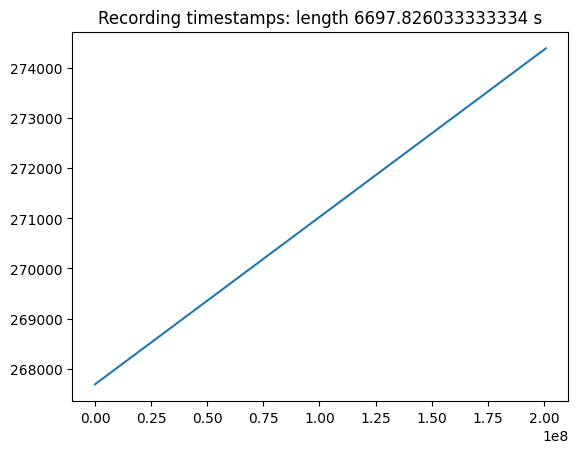

In [109]:
timestamps = recording.continuous[0].timestamps
fig = plt.Figure(figsize=(10,2))
plt.plot(timestamps[:])
plt.title(f'Recording timestamps: length {len(timestamps)/30000} s')
plt.show()

Text(0.5, 1.0, 'Total trigger: 420; Total recorded: 420')

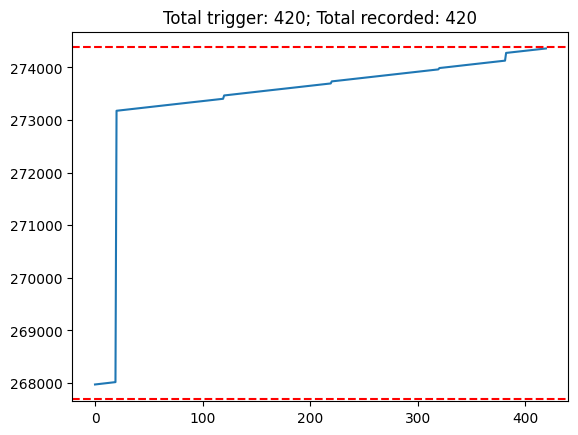

In [110]:
# extract laser times
laser_line = 2
events = recording.events
laser_events = events[
                (events.stream_name == 'PXIe-6341')
                & (events.line == laser_line)
                & (events.state == 1)
            ].sort_values(by='sample_number')
laser_times = np.sort(laser_events['timestamp'].values)
fig = plt.Figure(figsize=(6,3))
plt.plot(laser_times)
plt.axhline(y = np.max(timestamps), color = 'r', linestyle = '--')
plt.axhline(y = np.min(timestamps), color = 'r', linestyle = '--')
plt.title(f'Total trigger: {len(opto_df)}; Total recorded: {len(laser_events)}')

In [111]:
# adjustment
if len(laser_times) > len(opto_df):
    Print(f'{session_id} has more laser triggers than opto_df')
    laser_times = laser_times[1:]
    opto_df = opto_df[:len(laser_times)].copy()
    fig = plt.Figure(figsize=(6,3))
    plt.plot(laser_times)
    plt.axhline(y = np.max(timestamps), color = 'r', linestyle = '--')
    plt.axhline(y = np.min(timestamps), color = 'r', linestyle = '--')
    plt.title(f'Total trigger: {len(opto_df)}; Total recorded: {len(laser_times)}')
elif len(laser_times) < len(opto_df):
    print(f'{session_id} has more opto_df than laser triggers')
    opto_df = opto_df[:len(laser_times)].copy()
else:
    print(f'{session_id} has equal number of laser triggers and opto_df')


behavior_751004_2024-12-23_14-20-03 has equal number of laser triggers and opto_df


In [112]:
# save confirmed laser times
opto_df['time'] = laser_times
if 'emission_location' in opto_df.columns:
    opto_df = opto_df.drop(columns=['site'])
    opto_df['site'] = opto_df['emission_location']
opto_df.to_csv(os.path.join(session_dir['opto_tag_dir'], f'{session_id}_opto_session.csv'), index=False)

In [113]:
nwb = load_nwb_from_filename(session_dir['nwb_dir'])
unit_qc = nwb.units[:][['ks_unit_id', 'isi_violations_ratio', 'firing_rate', 'presence_ratio', 'amplitude_cutoff', 'decoder_label']]

In [114]:
# # load quality metrics
# if os.path.exists(session_dir['nwb_dir']):
#     nwb = load_nwb(session_dir['nwb_dir'])
#     unit_qc = nwb.units[:][['ks_unit_id', 'isi_violations_ratio', 'firing_rate', 'presence_ratio', 'amplitude_cutoff', 'decoder_label']]
# else:
#     qm = pd.read_csv(session_dir['qm_dir'], index_col=0)
#     unit_qc = qm[:][['isi_violations_ratio', 'firing_rate', 'presence_ratio', 'amplitude_cutoff']]
#     unit_qc['ks_unit_id'] = unit_qc.index
#     sorting = si.load_extractor(session_dir['curated_dir'])
#     label = sorting.get_property('decoder_label')
#     unit_qc['decoder_label'] = label


In [115]:
# load sample number from sorting results
sorting = si.load_extractor(session_dir['curated_dir'])
unit_ids = sorting.get_unit_ids()
unit_spikes = [timestamps[sorting.get_unit_spike_train(unit_id)] for unit_id in unit_ids]
unit_spikes = {unit_id:unit_spike for unit_id, unit_spike in zip(unit_ids, unit_spikes)}

In [116]:
target = 'soma'
if target == 'soma':
    resp_win = 25/1000 # seconds
    if 'emission_location' in opto_df.columns:
        opto_df_target = opto_df.query('site == "surface" or site == "surface_LC"')
    else:
        opto_df_target = opto_df
elif target == 'axon':
    resp_win = 50/1000 # seconds
    if 'emission_location' in opto_df.columns:
        opto_df_target = opto_df.query('site != "surface" and site != "surface_LC"')
    else:
        print('No axon data available')
        
opto_info = stim_params
opto_info['dimensions'] = ['power', 'site', 'num_pulses', 'duration', 'freq']
opto_info['resp_win'] = resp_win
opto_df_target.to_csv(os.path.join(session_dir['opto_tag_dir'], f'{session_id}_opto_session_{target}.csv'), index=False)

opto_info_target = {
    'sites': list(opto_df_target['site'].unique()),
    'powers': list(map(int,np.sort(opto_df_target['power'].unique()))),
    'freqs': list(map(int, np.sort(opto_df_target['freq'].unique()))),  # Convert to Python int
    'durations': list(map(int, np.sort(opto_df_target['duration'].unique()))),
    'num_pulses': list(map(int, np.sort(opto_df_target['num_pulses'].unique())))  # Convert to Python int
}

opto_info_target['dimensions'] = opto_info['dimensions']
opto_info_target['resp_win'] = resp_win


# write json file
with open(os.path.join(session_dir['opto_tag_dir'], f'{session_id}_opto_info_{target}.json'), 'w') as f:
    json.dump(opto_info_target, f)


In [117]:
dim_len = []
dim_len = [len(opto_df_target[dim].unique()) for dim in opto_info['dimensions']]
print(session_id)


for curr_id in unit_ids:
    spike_times = unit_spikes[curr_id]
    curr_resp_p = np.empty(tuple(dim_len), dtype=object)
    curr_resp_lat = np.empty(tuple(dim_len), dtype=object)
    for power_ind, curr_power in enumerate(np.sort(opto_df_target['power'].unique())):
        for site_ind, curr_site in enumerate(opto_df_target['site'].unique()):                                                             
            for duration_ind, curr_duration in enumerate(np.sort(opto_df_target['duration'].unique())):
                for freq_ind, curr_freq in enumerate(np.sort(opto_df_target['freq'].unique())):
                    for num_pulse_ind, curr_num_pulses in enumerate(np.sort(opto_df_target['num_pulses'].unique())):
                        laser_times_curr = opto_df_target.query('site == @curr_site and power == @curr_power and duration == @curr_duration and freq == @curr_freq and num_pulses == @curr_num_pulses')['time'].values
                        if len(laser_times_curr) == 0:
                            curr_resp_p[power_ind, site_ind, num_pulse_ind, duration_ind, freq_ind] = np.full(curr_num_pulses, np.nan).tolist()
                            curr_resp_lat[power_ind, site_ind, num_pulse_ind, duration_ind, freq_ind] = np.full(curr_num_pulses, np.nan).tolist()
                        else:
                            resp_temp = []
                            resp_lat_temp = []
                            for curr_pulse in range(curr_num_pulses):
                                laser_times_curr_pulse = laser_times_curr + curr_pulse * 1/curr_freq
                                df = align.to_events(spike_times, laser_times_curr_pulse, (0, resp_win), return_df=True)
                                resp_temp.append(len(df['event_index'].unique())/len(laser_times_curr_pulse))
                                if len(df) > 0:
                                    resp_lat_temp.append(np.nanmean(df.groupby('event_index')['time'].min().values))
                                else:
                                    resp_lat_temp.append(np.nan)
                            
                            curr_resp_lat[power_ind, site_ind, num_pulse_ind, duration_ind, freq_ind] = resp_lat_temp
                            curr_resp_p[power_ind, site_ind, num_pulse_ind, duration_ind, freq_ind] = resp_temp
    # save to unit_opto_tag
    np.save(os.path.join(session_dir['opto_tag_dir'], f'unit_opto_tag_p_{target}_{curr_id}.npy'), curr_resp_p)  
    np.save(os.path.join(session_dir['opto_tag_dir'], f'unit_opto_tag_lat_{target}_{curr_id}.npy'), curr_resp_lat)  
    np.save(os.path.join(session_dir['opto_tag_dir'], f'spiketimes_{curr_id}.npy'), spike_times)    
    print(f'Unit {curr_id} done')
    


behavior_751004_2024-12-23_14-20-03
Unit 0 done
Unit 1 done
Unit 2 done
Unit 3 done
Unit 4 done
Unit 5 done
Unit 6 done
Unit 7 done
Unit 8 done
Unit 9 done
Unit 10 done
Unit 11 done
Unit 12 done
Unit 13 done
Unit 14 done
Unit 15 done
Unit 16 done
Unit 17 done
Unit 18 done
Unit 19 done
Unit 20 done
Unit 21 done
Unit 22 done
Unit 23 done
Unit 24 done
Unit 25 done
Unit 26 done
Unit 27 done
Unit 28 done
Unit 29 done
Unit 30 done
Unit 31 done
Unit 32 done
Unit 33 done
Unit 35 done
Unit 36 done
Unit 37 done
Unit 38 done
Unit 39 done
Unit 40 done
Unit 41 done
Unit 42 done
Unit 43 done
Unit 44 done
Unit 45 done
Unit 46 done
Unit 47 done
Unit 48 done
Unit 49 done
Unit 50 done
Unit 51 done
Unit 52 done
Unit 53 done
Unit 54 done
Unit 55 done
Unit 56 done
Unit 57 done
Unit 58 done
Unit 59 done
Unit 60 done
Unit 61 done
Unit 62 done
Unit 63 done
Unit 64 done
Unit 65 done
Unit 66 done
Unit 67 done
Unit 68 done
Unit 69 done
Unit 70 done
Unit 71 done


Unit 72 done
Unit 73 done
Unit 74 done
Unit 75 done
Unit 76 done
Unit 77 done
Unit 78 done
Unit 79 done
Unit 80 done
Unit 81 done
Unit 82 done
Unit 83 done
Unit 84 done
Unit 85 done
Unit 86 done
Unit 87 done
Unit 88 done
Unit 89 done
Unit 90 done
Unit 91 done
Unit 92 done
Unit 93 done
Unit 94 done
Unit 95 done
Unit 96 done
Unit 97 done
Unit 98 done
Unit 99 done
Unit 100 done
Unit 101 done
Unit 102 done
Unit 103 done
Unit 104 done
Unit 105 done
Unit 106 done
Unit 107 done
Unit 108 done
Unit 109 done
Unit 110 done
Unit 111 done
Unit 112 done
Unit 113 done
Unit 114 done
Unit 115 done
Unit 116 done
Unit 117 done
Unit 118 done
Unit 119 done
Unit 120 done
Unit 121 done
Unit 122 done
Unit 123 done
Unit 124 done
Unit 126 done
Unit 127 done
Unit 128 done
Unit 129 done
Unit 130 done
Unit 131 done
Unit 132 done
Unit 133 done
Unit 134 done
Unit 135 done
Unit 136 done
Unit 137 done
Unit 138 done
Unit 139 done
Unit 140 done
Unit 141 done
Unit 142 done
Unit 143 done
Unit 144 done
Unit 145 done
Unit 1

In [118]:
# load waveforms info
we = si.load_sorting_analyzer_or_waveforms(session_dir['postprocessed_dir'])
unit_ids = we.sorting.get_unit_ids()
all_templates = we.get_extension("templates").get_data(operator="average")
all_channels = we.sparsity.channel_ids
if all_channels[0].startswith('AP'):
    all_channels_int = np.array([int(channel.split('AP')[-1]) for channel in all_channels])
else:
    all_channels_int = np.array([int(channel.split('CH')[-1]) for channel in all_channels])
unit_spartsiity = we.sparsity.unit_id_to_channel_ids
channel_locations = we.get_channel_locations()
unit_locations = we.load_extension("unit_locations").get_data(outputs="by_unit")
right_left = channel_locations[:, 0]<20

In [119]:
# re-organize templates so that left and right separate
colors = ["blue", "white", "red"]
b_w_r_cmap = LinearSegmentedColormap.from_list("b_w_r", colors)

y_neighbors_to_keep = 3
samples_to_keep = [-30, 60]
orginal_loc = False
waveform_params = {'samples_to_keep': samples_to_keep, 'y_neighbors_to_keep': y_neighbors_to_keep, 'orginal_loc': orginal_loc}
with open(os.path.join(session_dir['opto_tag_dir'], f'{session_id}_waveform_params.json'), 'w') as f:
    json.dump(waveform_params, f)

channel_loc_dict = {channel: channel_loc for channel, channel_loc in zip(all_channels_int, channel_locations)}

# save all re-ordered templates
print(session_id)
for unit_ind, unit_id in enumerate(unit_ids):
    curr_template = all_templates[unit_ind]
    reordered_template = template_reorder(curr_template, right_left, all_channels_int, sample_to_keep = samples_to_keep, y_neighbors_to_keep = y_neighbors_to_keep, orginal_loc = orginal_loc)
    # shifted_cmap = shiftedColorMap(custom_cmap, np.nanmin(reordered_template), np.nanmax(reordered_template), 'shifted_b_w_r')
    # plt.imshow(reordered_template, extent = [-30, -30+2*(30+60), 2*3+1, 0], cmap=shifted_cmap, aspect='auto');
    # plt.axvline(0, color='black', linestyle='--', linewidth=0.5)
    # plt.axvline(30+60, color='black', linestyle='--', linewidth=0.5)
    # plt.title(f'Unit_id: {unit_id} depth: {unit_locations[unit_id][1]:.2f}')
    # plt.box(False)
    # plt.colorbar();
    np.save(os.path.join(session_dir['opto_tag_dir'], f'unit_waveform_{unit_id}.npy'), reordered_template)
    print(f'Unit {unit_id} saved')

behavior_751004_2024-12-23_14-20-03
Unit 0 saved
Unit 1 saved
Unit 2 saved
Unit 3 saved
Unit 4 saved
Unit 5 saved
Unit 6 saved
Unit 7 saved
Unit 8 saved
Unit 9 saved
Unit 10 saved
Unit 11 saved
Unit 12 saved
Unit 13 saved
Unit 14 saved
Unit 15 saved
Unit 16 saved
Unit 17 saved
Unit 18 saved
Unit 19 saved
Unit 20 saved
Unit 21 saved
Unit 22 saved
Unit 23 saved
Unit 24 saved
Unit 25 saved
Unit 26 saved
Unit 27 saved
Unit 28 saved
Unit 29 saved
Unit 30 saved
Unit 31 saved
Unit 32 saved
Unit 33 saved
Unit 35 saved
Unit 36 saved
Unit 37 saved
Unit 38 saved
Unit 39 saved
Unit 40 saved
Unit 41 saved
Unit 42 saved
Unit 43 saved
Unit 44 saved
Unit 45 saved
Unit 46 saved
Unit 47 saved
Unit 48 saved
Unit 49 saved
Unit 50 saved
Unit 51 saved
Unit 52 saved
Unit 53 saved
Unit 54 saved
Unit 55 saved
Unit 56 saved
Unit 57 saved
Unit 58 saved
Unit 59 saved
Unit 60 saved
Unit 61 saved
Unit 62 saved
Unit 63 saved
Unit 64 saved
Unit 65 saved
Unit 66 saved
Unit 67 saved
Unit 68 saved
Unit 69 saved
Unit 70 